In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import os
from scipy import stats
import re
import itertools
import nilearn as nil
from nilearn.plotting import plot_stat_map, plot_glass_brain, show
import subprocess
import nilearn.image as image

os.chdir('../..')
data_dir='derivatives/Tensor_ICA'

/usr/local/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  if __name__ == '__main__':
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/utils/graph.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .graph_shortest_path import graph_shortest_path  # noqa
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset import ArrayDat

In [2]:
subj_mode=data_dir+'/Tensor_output_stimsassession.ica/melodic_Smodes'
df=pd.read_csv(subj_mode,delimiter=' ',header=None)
smode_df=df.dropna(axis='columns')
print(smode_df.shape)
display(smode_df.head())

(91, 19)


,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36
0,1.237485,0.675045,-0.514576,0.693507,-0.143649,0.130189,1.638262,0.535248,-1.049188,0.759660,0.291834,0.911360,-1.010706,0.672630,0.543675,0.055625,0.216883,-0.003167,-0.805680
1,-0.266724,1.833321,0.095487,0.606790,-1.204130,-0.981844,-2.719063,-0.951656,0.331775,-0.449201,-0.337316,1.836355,-0.100101,0.555219,-0.431748,10.821082,1.283864,0.033978,1.166227
2,-0.408151,-0.418047,0.092406,-0.280085,1.280945,-0.538024,-0.615204,-0.440261,-0.102813,0.189542,-0.940283,-0.805763,-0.364869,0.195753,0.114015,-0.241318,-0.403546,-0.204807,0.315001
3,1.580285,0.145660,0.360949,0.458983,0.462503,1.349625,1.668760,-1.167967,-0.716952,-0.122184,-1.679383,1.339862,-0.113850,-0.433269,-0.230334,-0.192707,0.005710,0.043498,-0.336798
4,-3.983110,-0.095951,-0.800904,-0.559674,1.154647,-0.138914,-0.064477,-2.921996,-0.084611,1.075890,1.908367,0.425795,0.069773,-5.239462,4.752323,-0.211191,-1.990274,0.074986,-0.219124


In [3]:
stim_files='zimages_all4stims.txt'
stim_df=pd.read_csv(stim_files,delimiter=' ',header=None)
sttim_df=stim_df.dropna(axis='columns')
print(stim_df.shape)
display(stim_df.head())
stim_df=stim_df.rename(columns={0:'file_name'})

stim_df['subj']=stim_df.file_name.apply(
    lambda x: 
    re.search('sub-(.*)/preproc_task',x)
    .group(1))
stim_df['stim']=stim_df.file_name.apply(
    lambda x: 
    re.search('stim-(.*)_sm-6',x)
    .group(1))
stim_df.head()

(91, 1)


,0
0,/data/projects/klab/rutgers-r21/derivatives/Te...
1,/data/projects/klab/rutgers-r21/derivatives/Te...
2,/data/projects/klab/rutgers-r21/derivatives/Te...
3,/data/projects/klab/rutgers-r21/derivatives/Te...
4,/data/projects/klab/rutgers-r21/derivatives/Te...


,file_name,subj,stim
0,/data/projects/klab/rutgers-r21/derivatives/Te...,189,BOTH
1,/data/projects/klab/rutgers-r21/derivatives/Te...,203,BOTH
2,/data/projects/klab/rutgers-r21/derivatives/Te...,207,BOTH
3,/data/projects/klab/rutgers-r21/derivatives/Te...,208,BOTH
4,/data/projects/klab/rutgers-r21/derivatives/Te...,209,BOTH


In [4]:
df=pd.concat([stim_df,smode_df],axis=1)
df.head()
df.columns=['file_name','subj','stim',
            'va1','va2','va3','va4','va5',
            'va6','va7','va8','va9','va10',
            'va11','va12','va13','va14','va15',
            'va16','va17','va18','va19']
df['yes_no_stim']=df.apply(lambda x: 'SHAMBOTH' in x.stim, axis=1)


In [36]:
import numbers
# deal with outliers now that we have a full rank matrix 
Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
lower=Q1-1.5*IQR
upper=Q3+1.5*IQR


#for i in range(1,52):
    #dep_val="val%s"%(i)
    #res_no_out=df.loc[(result[dep_val]>lower[dep_val])&(result[dep_val]<upper[dep_val])]


filter_col=[col for col
            in df if 
            'va' in col]

df=df[(np.abs(stats.zscore(df[filter_col]))<3).all(axis=1)]
display(df)

,file_name,subj,stim,va1,va2,va3,va4,va5,va6,va7,...,va11,va12,va13,va14,va15,va16,va17,va18,va19,yes_no_stim
0,/data/projects/klab/rutgers-r21/derivatives/Te...,189,BOTH,1.237485,0.675045,-0.514576,0.693507,-0.143649,0.130189,1.638262,...,0.291834,0.911360,-1.010706,0.672630,0.543675,0.055625,0.216883,-0.003167,-0.805680,False
2,/data/projects/klab/rutgers-r21/derivatives/Te...,207,BOTH,-0.408151,-0.418047,0.092406,-0.280085,1.280945,-0.538024,-0.615204,...,-0.940283,-0.805763,-0.364869,0.195753,0.114015,-0.241318,-0.403546,-0.204807,0.315001,False
3,/data/projects/klab/rutgers-r21/derivatives/Te...,208,BOTH,1.580285,0.145660,0.360949,0.458983,0.462503,1.349625,1.668760,...,-1.679383,1.339862,-0.113850,-0.433269,-0.230334,-0.192707,0.005710,0.043498,-0.336798,False
5,/data/projects/klab/rutgers-r21/derivatives/Te...,210,BOTH,0.183633,-0.270628,1.340719,0.117381,-0.355358,1.147673,0.530989,...,-0.726233,1.009435,-0.037247,0.448739,-0.084665,0.769549,-2.172986,0.737429,-1.587463,False
8,/data/projects/klab/rutgers-r21/derivatives/Te...,214,BOTH,-0.759105,-0.070479,-0.963897,-0.426021,-0.137568,-0.927340,0.249481,...,0.005589,1.373212,-0.022060,0.250766,0.427590,0.120965,0.369149,-0.479119,0.018763,False
13,/data/projects/klab/rutgers-r21/derivatives/Te...,220,BOTH,-0.661979,-0.524353,0.148988,0.082642,-0.447161,0.635735,-0.025213,...,-0.316997,0.056693,0.394864,-0.471697,-0.184410,-0.330609,0.077420,-0.461318,0.066226,False
14,/data/projects/klab/rutgers-r21/derivatives/Te...,221,BOTH,0.113537,-0.662965,0.395422,0.105552,1.163472,-0.572834,0.434598,...,0.387199,-0.384810,-0.052781,0.368675,0.208355,-0.320044,-0.244745,0.964784,0.194129,False
17,/data/projects/klab/rutgers-r21/derivatives/Te...,225,BOTH,1.448286,-1.108438,-0.051571,-0.496478,2.083846,0.435899,-0.030995,...,-1.884702,-0.404601,-0.765800,1.234693,-0.114375,-0.618294,0.146071,1.448358,0.012779,False
19,/data/projects/klab/rutgers-r21/derivatives/Te...,228,BOTH,-1.131395,0.518051,0.304641,-0.560183,-0.153587,-2.361812,0.010849,...,0.250919,-0.098813,0.013085,-0.028853,0.147879,0.480164,0.404119,-0.681709,0.291610,False
20,/data/projects/klab/rutgers-r21/derivatives/Te...,231,BOTH,-0.957996,0.031079,-2.363888,-0.371820,-0.290400,-1.765940,0.482889,...,-1.014976,1.573671,0.465071,0.191968,0.269833,0.835785,0.139110,-0.295637,-0.395869,False


In [6]:
df.to_csv(data_dir+'/best_data')
both=df.loc[df['stim']=='BOTH']
rtpj=df.loc[df['stim']=='RPTJ']
sham=df.loc[df['stim']=='SHAMBOTH']
vlpfc=df.loc[df['stim']=='VLPFC']
#df=res_no_out.loc[res_no_out['Group']==0]
for i in filter_col:
    dep_val=i
    print(dep_val)
    F,p=stats.f_oneway(both[i],rtpj[i],sham[i],vlpfc[i])
    print(F,p)

va1
(0.9568943905033704, 0.4190353087279909)
va2
(1.9931196820529165, 0.12460891391889517)
va3
(0.023746891206345693, 0.9949932146279663)
va4
(0.39118624156092546, 0.7597677519334628)
va5
(0.24064110856303908, 0.8676518049137615)
va6
(0.806084334541632, 0.49543411536995674)
va7
(1.990665710705498, 0.12497420273498978)
va8
(0.3807914188282301, 0.7671902988774901)
va9
(0.008123405731260717, 0.9989834095578873)
va10
(3.372232363972243, 0.02413898114802333)
va11
(0.0599764645107486, 0.9805739114478482)
va12
(1.6339848101106251, 0.19098674357142367)
va13
(0.26637321374948353, 0.849369599285769)
va14
(2.793775125631758, 0.04791897618309222)
va15
(0.2088355565493297, 0.8898984168460556)
va16
(0.013268925281872818, 0.9978880407455996)
va17
(0.1608031151497269, 0.922293258428967)
va18
(1.1171507279391184, 0.3493075884347658)
va19
(0.2910333552584324, 0.8317036310183611)


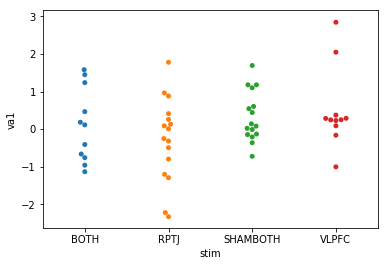

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va1     
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.9113  
Min. group size:     1        Likelihood:          -73.9280
Max. group size:     4        Converged:           No      
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.104    0.327  0.318 0.751 -0.537  0.744
stim[T.RPTJ]     -0.376    0.390 -0.964 0.335 -1.141  0.388
stim[T.SHAMBOTH]  0.235    0.387  0.609 0.543 -0.522  0.993
stim[T.VLPFC]     0.399    0.408  0.977 0.329 -0.401  1.198
Group Var         0.005    0.273                           



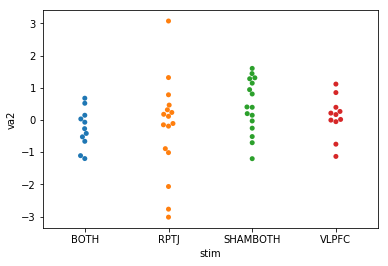

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va2     
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               1.0464  
Min. group size:     1        Likelihood:          -77.2638
Max. group size:     4        Converged:           No      
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.262    0.305 -0.859 0.391 -0.861  0.336
stim[T.RPTJ]      0.028    0.393  0.072 0.943 -0.743  0.799
stim[T.SHAMBOTH]  0.696    0.401  1.737 0.082 -0.089  1.481
stim[T.VLPFC]     0.360    0.436  0.825 0.410 -0.495  1.214
Group Var         0.001                                    



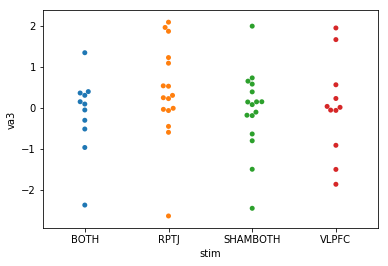

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va3     
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               1.1420  
Min. group size:     1        Likelihood:          -79.4375
Max. group size:     4        Converged:           No      
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.141    0.313 -0.451 0.652 -0.754  0.472
stim[T.RPTJ]      0.532    0.409  1.303 0.193 -0.268  1.333
stim[T.SHAMBOTH]  0.079    0.418  0.189 0.850 -0.741  0.899
stim[T.VLPFC]     0.146    0.451  0.324 0.746 -0.737  1.030
Group Var         0.000                                    



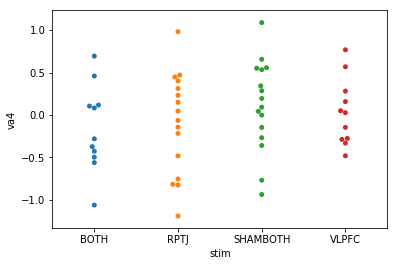

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va4     
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.1883  
Min. group size:     1        Likelihood:          -41.7805
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.149    0.153 -0.972 0.331 -0.448  0.151
stim[T.RPTJ]      0.068    0.177  0.386 0.700 -0.279  0.416
stim[T.SHAMBOTH]  0.238    0.177  1.347 0.178 -0.108  0.584
stim[T.VLPFC]     0.193    0.191  1.006 0.314 -0.182  0.568
Group Var         0.087    0.167                           



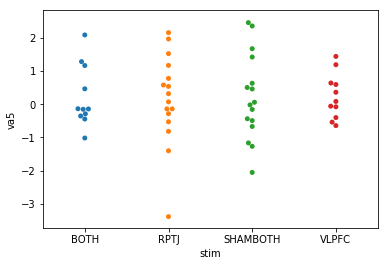

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va5     
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               1.1511  
Min. group size:     1        Likelihood:          -82.5566
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.231    0.343  0.674 0.500 -0.441  0.904
stim[T.RPTJ]     -0.086    0.428 -0.201 0.841 -0.925  0.753
stim[T.SHAMBOTH] -0.045    0.427 -0.106 0.916 -0.883  0.792
stim[T.VLPFC]    -0.018    0.465 -0.039 0.969 -0.930  0.894
Group Var         0.160    0.242                           



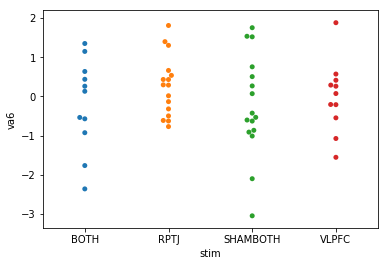

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va6     
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.8781  
Min. group size:     1        Likelihood:          -77.9295
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.299    0.322 -0.929 0.353 -0.930  0.332
stim[T.RPTJ]      0.500    0.380  1.317 0.188 -0.244  1.244
stim[T.SHAMBOTH]  0.049    0.381  0.128 0.898 -0.698  0.796
stim[T.VLPFC]     0.222    0.410  0.541 0.588 -0.582  1.026
Group Var         0.241    0.265                           



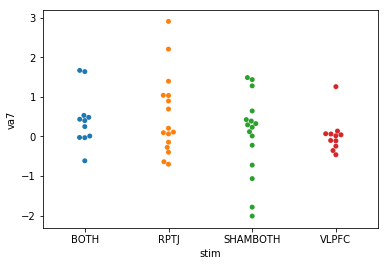

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va7     
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.7476  
Min. group size:     1        Likelihood:          -69.2343
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.428    0.267  1.602 0.109 -0.096  0.951
stim[T.RPTJ]      0.102    0.342  0.299 0.765 -0.568  0.772
stim[T.SHAMBOTH] -0.375    0.344 -1.089 0.276 -1.050  0.300
stim[T.VLPFC]    -0.393    0.393 -1.001 0.317 -1.164  0.377
Group Var         0.012    0.198                           



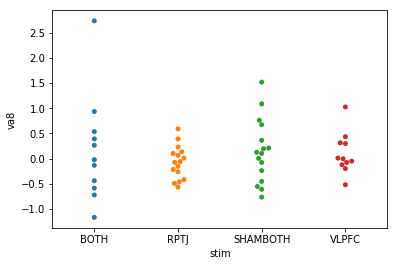

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va8     
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.4042  
Min. group size:     1        Likelihood:          -53.4778
Max. group size:     4        Converged:           No      
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.162    0.192  0.845 0.398 -0.214  0.538
stim[T.RPTJ]     -0.237    0.249 -0.949 0.342 -0.725  0.252
stim[T.SHAMBOTH] -0.017    0.249 -0.067 0.947 -0.505  0.472
stim[T.VLPFC]    -0.062    0.271 -0.228 0.819 -0.593  0.470
Group Var         0.000    0.082                           



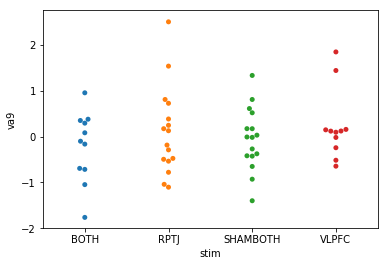

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va9     
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.6458  
Min. group size:     1        Likelihood:          -65.2080
Max. group size:     4        Converged:           No      
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.222    0.241 -0.921 0.357 -0.694  0.250
stim[T.RPTJ]      0.320    0.311  1.030 0.303 -0.289  0.929
stim[T.SHAMBOTH]  0.167    0.315  0.532 0.595 -0.450  0.784
stim[T.VLPFC]     0.448    0.342  1.308 0.191 -0.223  1.119
Group Var         0.001                                    



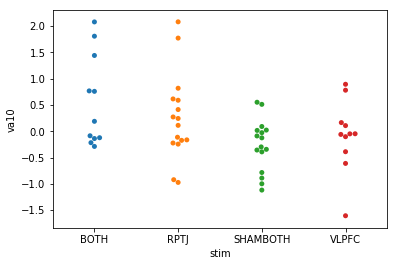

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va10    
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.4145  
Min. group size:     1        Likelihood:          -58.6829
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.600    0.215  2.794 0.005  0.179  1.020
stim[T.RPTJ]     -0.355    0.262 -1.358 0.175 -0.868  0.158
stim[T.SHAMBOTH] -0.828    0.258 -3.212 0.001 -1.333 -0.323
stim[T.VLPFC]    -0.643    0.281 -2.290 0.022 -1.193 -0.093
Group Var         0.100    0.160                           



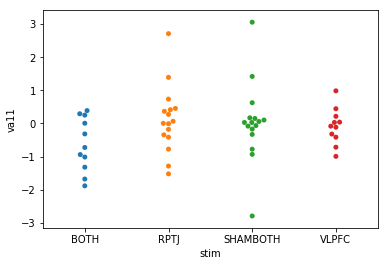

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va11    
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.9030  
Min. group size:     1        Likelihood:          -73.9291
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.626    0.294 -2.132 0.033 -1.201 -0.051
stim[T.RPTJ]      0.742    0.378  1.963 0.050  0.001  1.483
stim[T.SHAMBOTH]  0.654    0.381  1.715 0.086 -0.093  1.400
stim[T.VLPFC]     0.543    0.408  1.330 0.184 -0.257  1.342
Group Var         0.013    0.140                           



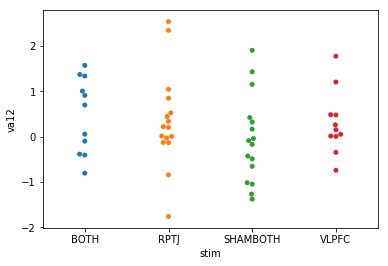

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va12    
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.8366  
Min. group size:     1        Likelihood:          -71.6849
Max. group size:     4        Converged:           No      
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.480    0.218  2.200 0.028  0.052  0.907
stim[T.RPTJ]     -0.126    0.351 -0.359 0.719 -0.814  0.562
stim[T.SHAMBOTH] -0.553    0.311 -1.776 0.076 -1.162  0.057
stim[T.VLPFC]    -0.175    0.387 -0.452 0.651 -0.933  0.583
Group Var         0.001                                    



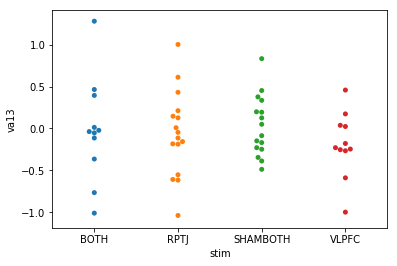

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va13    
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.1934  
Min. group size:     1        Likelihood:          -38.0314
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.016    0.141 -0.112 0.911 -0.292  0.261
stim[T.RPTJ]     -0.037    0.176 -0.211 0.833 -0.381  0.307
stim[T.SHAMBOTH]  0.067    0.177  0.381 0.703 -0.279  0.414
stim[T.VLPFC]    -0.151    0.192 -0.788 0.430 -0.528  0.225
Group Var         0.028    0.111                           



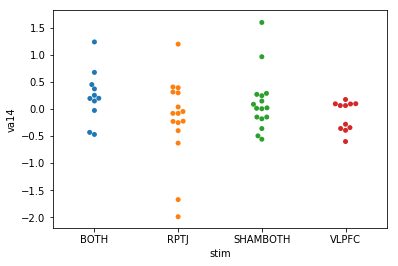

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va14    
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.3236  
Min. group size:     1        Likelihood:          -47.9107
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.234    0.173  1.355 0.175 -0.104  0.573
stim[T.RPTJ]     -0.421    0.223 -1.887 0.059 -0.858  0.016
stim[T.SHAMBOTH] -0.127    0.223 -0.570 0.569 -0.565  0.310
stim[T.VLPFC]    -0.363    0.243 -1.494 0.135 -0.838  0.113
Group Var         0.000    0.085                           



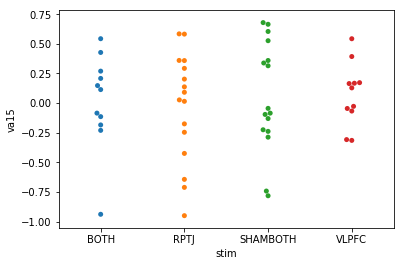

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va15    
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.1744  
Min. group size:     1        Likelihood:          -32.4633
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.014    0.127  0.114 0.909 -0.234  0.263
stim[T.RPTJ]     -0.046    0.166 -0.276 0.782 -0.370  0.279
stim[T.SHAMBOTH]  0.039    0.164  0.238 0.812 -0.283  0.361
stim[T.VLPFC]     0.059    0.181  0.325 0.745 -0.296  0.414
Group Var         0.000    0.065                           



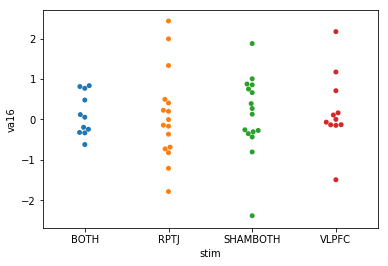

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va16    
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.8698  
Min. group size:     1        Likelihood:          -72.6341
Max. group size:     4        Converged:           No      
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.125    0.284  0.440 0.660 -0.431  0.680
stim[T.RPTJ]     -0.050    0.365 -0.135 0.892 -0.766  0.667
stim[T.SHAMBOTH]  0.002    0.367  0.006 0.995 -0.717  0.721
stim[T.VLPFC]     0.091    0.403  0.226 0.821 -0.699  0.881
Group Var         0.000    0.162                           



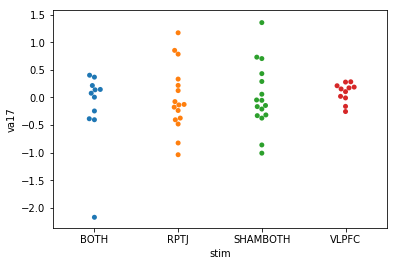

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va17    
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.3231  
Min. group size:     1        Likelihood:          -47.8729
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.168    0.173 -0.974 0.330 -0.506  0.170
stim[T.RPTJ]      0.145    0.223  0.649 0.516 -0.292  0.581
stim[T.SHAMBOTH]  0.172    0.223  0.773 0.440 -0.265  0.610
stim[T.VLPFC]     0.259    0.242  1.068 0.286 -0.216  0.734
Group Var         0.000    0.066                           



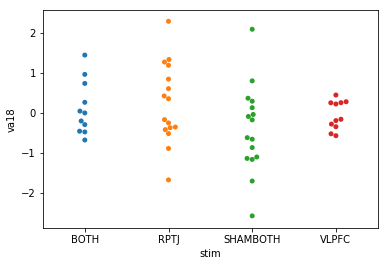

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va18    
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.5759  
Min. group size:     1        Likelihood:          -69.1281
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.107    0.264  0.407 0.684 -0.409  0.624
stim[T.RPTJ]      0.108    0.309  0.348 0.728 -0.499  0.714
stim[T.SHAMBOTH] -0.474    0.310 -1.528 0.126 -1.081  0.134
stim[T.VLPFC]    -0.146    0.335 -0.434 0.664 -0.803  0.512
Group Var         0.236    0.396                           



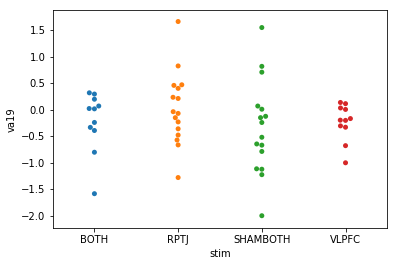

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  va19    
No. Observations:    54       Method:              REML    
No. Groups:          22       Scale:               0.4583  
Min. group size:     1        Likelihood:          -56.6138
Max. group size:     4        Converged:           Yes     
Mean group size:     2.5                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.225    0.204 -1.100 0.271 -0.625  0.175
stim[T.RPTJ]      0.248    0.265  0.934 0.350 -0.272  0.767
stim[T.SHAMBOTH] -0.119    0.265 -0.449 0.653 -0.639  0.401
stim[T.VLPFC]    -0.014    0.289 -0.050 0.960 -0.581  0.552
Group Var         0.000    0.092                           



In [38]:
import statsmodels.formula.api as smf

for i in filter_col:
    sb.swarmplot(data=df,x='stim',y='%s'%(i))
    plt.show()
    md=smf.mixedlm("%s~stim"%(i),df,groups=df["subj"])
    res=md.fit()
    print(res.summary())

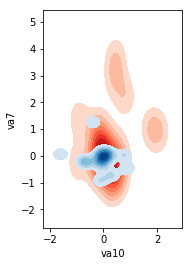

In [35]:
f,ax=plt.subplots()
ax.set_aspect("equal")
ax=sb.kdeplot(rtpj.va10,rtpj.va7,cmap="Reds",shade=True, shade_lowest=False)
ax=sb.kdeplot(vlpfc.va10,vlpfc.va7,cmap="Blues",shade=True, shade_lowest=False)

#f=sb.pairplot(vars=['va10','va7','va14'],data=df,hue='stim',kind='kde')
plt.show(f)

UsageError: Line magic function `%r` not found.
